In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#ucimlrepo is for the data
from ucimlrepo import fetch_ucirepo 


 # Fetch the Breast Cancer Wisconsin dataset from UCI repository
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Get the features (X) and targets (y) as pandas DataFrames
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Print columns to verify the structure
#print("Feature columns:\n", X.columns)
#print("Target columns:\n", y.columns)

y = y.iloc[:, 0]  # extract the Series

# Map the diagnosis labels: 1 for malignant ('M'), 0 for benign ('B')
y = y.map({'M': 1, 'B': 0})  # Adjust this mapping as per the dataset's structure

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the input dimension
input_dim = X_train.shape[1]

# take a subset of the training data that only has benign samples
X_train_benign = X_train[y_train == 0]

# input dimension for the benign model
input_dim_benign = X_train_benign.shape[1]

#take a subset of the training data that only has malignant samples
X_train_malignant = X_train[y_train == 1]

# input dimension for the malignant model
input_dim_malignant = X_train_malignant.shape[1]


In [2]:
# function to define the shared model arhitecture 
def create_autoencoder(input_dim):
    model = Sequential([
        Dense(14, activation='relu', input_shape=(input_dim,)),
        Dense(7, activation='relu'),
        Dense(14, activation='relu'),
        Dense(input_dim, activation='linear')
    ])
    return model


# Create the standard  autoencoder models
autoencoder_normal = create_autoencoder(input_dim)
autoencoder_benign = create_autoencoder(input_dim_benign)
autoencoder_malignant = create_autoencoder(input_dim_malignant)


# Compile the standard models witht the adam optimizer
autoencoder_normal.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_benign.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_malignant.compile(optimizer='adam', loss='mean_squared_error')


# train the standard models
autoencoder_normal.fit(X_train, X_train, epochs=10, batch_size=32,verbose=1)
autoencoder_benign.fit(X_train_benign, X_train_benign, epochs=10, batch_size=32,verbose=1)
autoencoder_malignant.fit(X_train_malignant, X_train_malignant, epochs=10, batch_size=32,verbose=1)





Epoch 1/10
15/15 [==============================] - 0s 730us/step - loss: 1.1485
Epoch 2/10
15/15 [==============================] - 0s 713us/step - loss: 1.0573
Epoch 3/10


2024-08-29 13:42:38.585129: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 0s 678us/step - loss: 1.0057
Epoch 4/10
15/15 [==============================] - 0s 608us/step - loss: 0.9639
Epoch 5/10
15/15 [==============================] - 0s 693us/step - loss: 0.9129
Epoch 6/10
15/15 [==============================] - 0s 734us/step - loss: 0.8451
Epoch 7/10
15/15 [==============================] - 0s 707us/step - loss: 0.7723
Epoch 8/10
15/15 [==============================] - 0s 746us/step - loss: 0.7019
Epoch 9/10
15/15 [==============================] - 0s 690us/step - loss: 0.6485
Epoch 10/10
15/15 [==============================] - 0s 690us/step - loss: 0.6074
Epoch 1/10
9/9 [==============================] - 0s 932us/step - loss: 0.7271
Epoch 2/10
9/9 [==============================] - 0s 917us/step - loss: 0.6977
Epoch 3/10
9/9 [==============================] - 0s 969us/step - loss: 0.6744
Epoch 4/10
9/9 [==============================] - 0s 741us/step - loss: 0.6526
Epoch 5/10
9/9 [==============================

In [3]:

# Create the custom loss fuction for the modified model
from base64 import standard_b64decode


def custom_loss_pos(X_batch, X_pred, labels_batch):
    # Compute the MSE between the true input and the reconstructed input
    mse = tf.reduce_mean(tf.square(X_batch - X_pred), axis=1)

    # standard batch-level MSE
    standard_batch_level_mse = tf.reduce_mean(mse)

    # standard batch-level MSE using reduce_sum
    standard_batch_level_mse_reduce_sum = tf.reduce_sum(mse) / len(labels_batch)

    # Create a mask to include only those points where labels == 0
    mask = tf.cast(labels_batch == 0, dtype=tf.float32)
    mask = tf.reshape(mask, [-1])  # Flatten to shape [batch_size]

    # Create the inverse mask
    inverse_mask = 1 - mask

    # Apply the mask to the MSE
    masked_mse = mse * mask

    # Apply the inverse mask to the MSE
    inverse_masked_mse = mse * inverse_mask

    # Calculate the masked batch-level MSE
    masked_numerator = tf.reduce_sum(masked_mse)
    masked_denominator = tf.reduce_sum(mask)
    masked_batch_level_mse = masked_numerator / masked_denominator

    # Calculate the inverse masked batch-level MSE
    inverse_masked_numerator = tf.reduce_sum(inverse_masked_mse)
    inverse_masked_denominator = tf.reduce_sum(inverse_mask)
    inverse_masked_batch_level_mse = inverse_masked_numerator / inverse_masked_denominator
    
    
    # print debug information
    tf.print("-----------------------------")
    tf.print("Standard batch-level MSE:", standard_batch_level_mse)
    tf.print("Standard batch-level MSE using reduce_sum:", standard_batch_level_mse_reduce_sum)
    tf.print("Mask length:", tf.reduce_sum(mask))
    tf.print("Inverse mask length:", tf.reduce_sum(inverse_mask))
    tf.print("n lables in batch:", len(labels_batch))
    tf.print(" ")
    tf.print("masked sum:", tf.reduce_sum(masked_mse))
    tf.print("inverse masked sum:", tf.reduce_sum(inverse_masked_mse))
    tf.print(" ")
    tf.print("masked numerator:", masked_numerator)
    tf.print("unmasked numerator:", inverse_masked_numerator)
    tf.print("masked denominator:", masked_denominator)
    tf.print("unmasked denominator:", inverse_masked_denominator)
    tf.print("Masked batch level MSE:", masked_batch_level_mse)
    tf.print("Inverse masked batch level MSE:", inverse_masked_batch_level_mse)
    tf.print(" ")
    tf.print("point level mse:", mse)
    tf.print(" ")
    tf.print("mse shape:", mse.shape)
    tf.print("mask shape:", mask.shape)
    tf.print("inverse mask shape:", inverse_mask.shape)
    tf.print("mask", mask)
    tf.print("inverse mask", inverse_mask)
    tf.print("masked point level mse:", masked_mse)
    tf.print("inverse masked point level mse:", inverse_masked_mse)
    # Return the masked MSE 
    return masked_mse


In [4]:

# Convert X_train and y_train to float32 if not already converted
if X_train.dtype != tf.float32:
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)

if y_train.dtype != tf.float32:
    y_train = tf.convert_to_tensor(y_train.values.reshape(-1, 1), dtype=tf.float32)

# Create a dataset that includes features and labels
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
batch_size = 32
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Define the autoencoder model (make sure it also outputs float32)
autoencoder_pos = create_autoencoder(input_dim)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Number of epochs to train
num_epochs = 10

# Custom training loop to replicate `model.fit`
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Iterate over the batches of the dataset
    for step, (X_batch, labels_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward pass: Compute predictions
            X_pred = autoencoder_pos(X_batch, training=True)

            # Compute the loss using the custom loss function
            loss = custom_loss_pos(X_batch, X_pred, labels_batch)
        
        # Compute gradients
        gradients = tape.gradient(loss, autoencoder_pos.trainable_weights)

        # Apply gradients to update the model's weights
        optimizer.apply_gradients(zip(gradients, autoencoder_pos.trainable_weights))
        
        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.numpy()}")

    # Print the loss for the epoch (optional, for monitoring)
    print(f"Epoch {epoch+1} completed with final batch loss: {loss.numpy()}")

Epoch 1/10
-----------------------------
Standard batch-level MSE: 1.26178348
Standard batch-level MSE using reduce_sum: 1.26178348
Mask length: 26
Inverse mask length: 6
n lables in batch: 32
 
masked sum: 33.388443
inverse masked sum: 6.98863125
 
masked numerator: 33.388443
unmasked numerator: 6.98863125
masked denominator: 26
unmasked denominator: 6
Masked batch level MSE: 1.28417087
Inverse masked batch level MSE: 1.16477191
 
point level mse: [1.05708814 1.12369573 0.571552336 ... 0.399199903 0.922481239 0.632239699]
 
mse shape: TensorShape([32])
mask shape: TensorShape([32])
inverse mask shape: TensorShape([32])
mask [1 1 0 ... 1 1 1]
inverse mask [0 0 1 ... 0 0 0]
masked point level mse: [1.05708814 1.12369573 0 ... 0.399199903 0.922481239 0.632239699]
inverse masked point level mse: [0 0 0.571552336 ... 0 0 0]
Step 0: Loss = [1.0570881  1.1236957  0.         1.5123093  0.         0.6859636
 0.         1.0068898  0.5234696  2.4308188  1.5492734  0.39305407
 0.8698703  0.      

2024-08-29 13:42:39.446520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [455,1]
	 [[{{node Placeholder/_1}}]]
2024-08-29 13:42:39.446665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [455,1]
	 [[{{node Placeholder/_1}}]]


-----------------------------
Standard batch-level MSE: 1.33759427
Standard batch-level MSE using reduce_sum: 1.33759427
Mask length: 18
Inverse mask length: 14
n lables in batch: 32
 
masked sum: 20.0552483
inverse masked sum: 22.7477627
 
masked numerator: 20.0552483
unmasked numerator: 22.7477627
masked denominator: 18
unmasked denominator: 14
Masked batch level MSE: 1.11418045
Inverse masked batch level MSE: 1.62484014
 
point level mse: [1.13122976 9.40192127 0.54452157 ... 0.408056587 2.36322331 0.48443529]
 
mse shape: TensorShape([32])
mask shape: TensorShape([32])
inverse mask shape: TensorShape([32])
mask [0 0 1 ... 0 0 0]
inverse mask [1 1 0 ... 1 1 1]
masked point level mse: [0 0 0.54452157 ... 0 0 0]
inverse masked point level mse: [1.13122976 9.40192127 0 ... 0.408056587 2.36322331 0.48443529]
-----------------------------
Standard batch-level MSE: 1.43153
Standard batch-level MSE using reduce_sum: 1.43153
Mask length: 21
Inverse mask length: 11
n lables in batch: 32
 
ma

In [5]:
#get feature-level reconstruction errors for positive and negative autoencoder
X_test_normal = autoencoder_normal.predict(X_test)
X_test_benign = autoencoder_benign.predict(X_test)
X_test_malignant = autoencoder_malignant.predict(X_test)
X_test_pos = autoencoder_pos.predict(X_test)

# get the patient-level (ie point-level) reconstruction errors (ie the scores)
scores_normal = np.mean(np.power(X_test - X_test_normal, 2), axis=1)
scores_benign = np.mean(np.power(X_test - X_test_benign, 2), axis=1)
scores_malignant = np.mean(np.power(X_test - X_test_malignant, 2), axis=1)
scores_pos = np.mean(np.power(X_test - X_test_pos, 2), axis=1)

# Calculate the rocs and aucs
fpr_normal, tpr_normal, _ = roc_curve(y_test, scores_normal)
roc_auc_normal = auc(fpr_normal, tpr_normal)
fpr_benign, tpr_benign, _ = roc_curve(y_test, scores_benign)
roc_auc_benign = auc(fpr_benign, tpr_benign)
fpr_malignant, tpr_malignant, _ = roc_curve(y_test, scores_malignant)
roc_auc_malignant = auc(fpr_malignant, tpr_malignant)
fpr_pos, tpr_pos, _ = roc_curve(y_test, scores_pos)
roc_auc_pos = auc(fpr_pos, tpr_pos)

4/4 [==============================] - 0s 610us/step


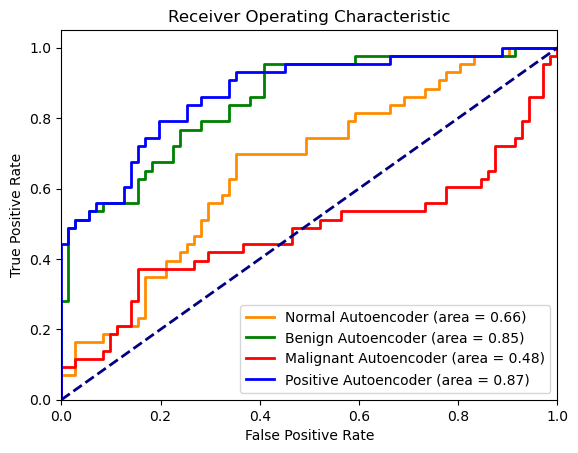

In [6]:
# plot the roc curves
plt.figure()
lw = 2
plt.plot(fpr_normal, tpr_normal, color='darkorange', lw=lw, label='Normal Autoencoder (area = %0.2f)' % roc_auc_normal)
plt.plot(fpr_benign, tpr_benign, color='green', lw=lw, label='Benign Autoencoder (area = %0.2f)' % roc_auc_benign)
plt.plot(fpr_malignant, tpr_malignant, color='red', lw=lw, label='Malignant Autoencoder (area = %0.2f)' % roc_auc_malignant)
plt.plot(fpr_pos, tpr_pos, color='blue', lw=lw, label='Positive Autoencoder (area = %0.2f)' % roc_auc_pos)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
